In [ ]:
import pandas as pd
import warnings
warnings.filterwarnings("ignore")

In [ ]:
data = pd.read_csv('Breast_Cancer_dataset.csv')
print(data.shape)
data.head()

(4024, 16)


,Age,Race,Marital Status,T Stage,N Stage,6th Stage,differentiate,Grade,A Stage,Tumor Size,Estrogen Status,Progesterone Status,Regional Node Examined,Reginol Node Positive,Survival Months,Status
0,68,White,Married,T1,N1,IIA,Poorly differentiated,3,Regional,4,Positive,Positive,24,1,60,Alive
1,50,White,Married,T2,N2,IIIA,Moderately differentiated,2,Regional,35,Positive,Positive,14,5,62,Alive
2,58,White,Divorced,T3,N3,IIIC,Moderately differentiated,2,Regional,63,Positive,Positive,14,7,75,Alive
3,58,White,Married,T1,N1,IIA,Poorly differentiated,3,Regional,18,Positive,Positive,2,1,84,Alive
4,47,White,Married,T2,N1,IIB,Poorly differentiated,3,Regional,41,Positive,Positive,3,1,50,Alive


# Step1: Preprocessing

In [ ]:
from sklearn.neighbors import NearestNeighbors
import matplotlib.pyplot as plt
from sklearn.cluster import DBSCAN
from sklearn.preprocessing import StandardScaler

In [ ]:
# Check missing values: No missing value
data.isna().sum()[data.isna().sum() > 0].sort_values(ascending=False).to_frame(name='Number of NA')

,Number of NA


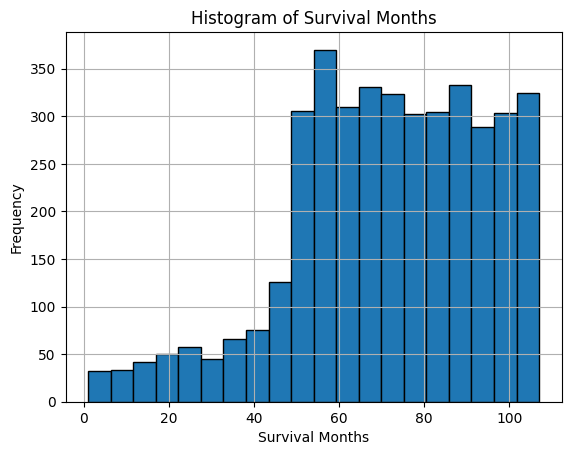

In [ ]:
# Check outliers based on numerical data
# For the features in the dataset, the column that is the most likely to contain outliers is "Survival Months" -> Check with a histogram
# According to the histogram below, there's no obvious outlier in the dataset (not removing any data point)
plt.hist(data['Survival Months'], bins=20, edgecolor='k')
plt.title('Histogram of Survival Months')
plt.xlabel('Survival Months')
plt.ylabel('Frequency')
plt.grid(True)
plt.show()

# Step2: Modeling

## Feature selection & Feature ranking

In [ ]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.feature_selection import SelectFromModel

In [ ]:
# Feature ranking with Random Forest
features = data.drop('Status', axis=1)
label = data['Status'].to_frame()
label = label.applymap(lambda x: 1 if x == "Alive" else 0)

# Apply one-hot encoding before modeling
cat_cols = ['Race', 'Marital Status', 'T Stage ', 'N Stage', '6th Stage', 'differentiate', 'A Stage', 'Estrogen Status', 'Progesterone Status']
features_encoded = pd.get_dummies(features, columns=cat_cols)
features_encoded = features_encoded.applymap(lambda x: 1 if x == True else 0)
print(features_encoded.shape)
# print(features_encoded.dtypes)
features_encoded.head()

(4024, 36)


,Age,Grade,Tumor Size,Regional Node Examined,Reginol Node Positive,Survival Months,Race_Black,Race_Other,Race_White,Marital Status_Divorced,...,differentiate_Moderately differentiated,differentiate_Poorly differentiated,differentiate_Undifferentiated,differentiate_Well differentiated,A Stage_Distant,A Stage_Regional,Estrogen Status_Negative,Estrogen Status_Positive,Progesterone Status_Negative,Progesterone Status_Positive
0,0,0,0,0,1,0,0,0,1,0,...,0,1,0,0,0,1,0,1,0,1
1,0,0,0,0,0,0,0,0,1,0,...,1,0,0,0,0,1,0,1,0,1
2,0,0,0,0,0,0,0,0,1,1,...,1,0,0,0,0,1,0,1,0,1
3,0,0,0,0,1,0,0,0,1,0,...,0,1,0,0,0,1,0,1,0,1
4,0,0,0,0,1,0,0,0,1,0,...,0,1,0,0,0,1,0,1,0,1


Feature ranking with randome forest classifier

In [ ]:
# Rank the features with random forest classifier
rf = RandomForestClassifier()
rf.fit(features_encoded, label)
importances = rf.feature_importances_
# Get feature names
feature_names = features_encoded.columns
features_importance_dict = dict(zip(feature_names, importances))
features_importance_df = pd.DataFrame(list(features_importance_dict.items()), columns=['Feature', 'Importance'])
features_importance_df = features_importance_df.sort_values(by='Importance', ascending=False).reset_index(drop=True)
# Feature ranking based on random forest
print(features_importance_df.shape)
features_importance_df

(36, 2)


,Feature,Importance
0,Marital Status_Married,0.053740
1,Reginol Node Positive,0.051700
2,differentiate_Moderately differentiated,0.048176
3,differentiate_Poorly differentiated,0.047309
4,6th Stage_IIIC,0.046572
5,N Stage_N1,0.045642
6,Marital Status_Single,0.044344
7,N Stage_N3,0.041478
8,Race_White,0.041160
9,Marital Status_Divorced,0.040861


from matplotlib import pyplot as plt
_df_0['index'].plot(kind='hist', bins=20, title='index')
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
_df_1['Importance'].plot(kind='hist', bins=20, title='Importance')
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
_df_2.plot(kind='scatter', x='index', y='Importance', s=32, alpha=.8)
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
import seaborn as sns
def _plot_series(series, series_name, series_index=0):
  palette = list(sns.palettes.mpl_palette('Dark2'))
  xs = series['index']
  ys = series['Importance']
  
  plt.plot(xs, ys, label=series_name, color=palette[series_index % len(palette)])

fig, ax = plt.subplots(figsize=(10, 5.2), layout='constrained')
df_sorted = _df_3.sort_values('index', ascending=True)
_plot_series(df_sorted, '')
sns.despine(fig=fig, ax=ax)
plt.xlabel('index')
_ = plt.ylabel('Importance')

from matplotlib import pyplot as plt
import seaborn as sns
def _plot_series(series, series_name, series_index=0):
  palette = list(sns.palettes.mpl_palette('Dark2'))
  counted = (series['index']
                .value_counts()
              .reset_index(name='counts')
              .rename({'index': 'index'}, axis=1)
              .sort_values('index', ascending=True))
  xs = counted['index']
  ys = counted['counts']
  plt.plot(xs, ys, label=series_name, color=palette[series_index % len(palette)])

fig, ax = plt.subplots(figsize=(10, 5.2), layout='constrained')
df_sorted = _df_4.sort_values('index', ascending=True)
_plot_series(df_sorted, '')
sns.despine(fig=fig, ax=ax)
plt.xlabel('index')
_ = plt.ylabel('count()')

from matplotlib import pyplot as plt
_df_5['index'].plot(kind='line', figsize=(8, 4), title='index')
plt.gca().spines[['top', 'right']].set_visible(False)

from matplotlib import pyplot as plt
_df_6['Importance'].plot(kind='line', figsize=(8, 4), title='Importance')
plt.gca().spines[['top', 'right']].set_visible(False)

Feature selection

In [ ]:
# Do feature selection based on the random forest model's importance scores
selector = SelectFromModel(rf, prefit=True)
selected_features = selector.transform(features_encoded)
# Get the support for the features used in the reduced set
selected_features_mask = selector.get_support()

# Get the DataFrame with the selected feature names and their importances
selected_features_df = features_importance_df.loc[selected_features_mask]
print("# of features selected: {}".format(selected_features_df.shape[0]))
selected_features_df

# of features selected: 19


,Feature,Importance
4,6th Stage_IIIC,0.046572
6,Marital Status_Single,0.044344
8,Race_White,0.041160
9,Marital Status_Divorced,0.040861
10,Race_Black,0.040390
12,Progesterone Status_Negative,0.038810
13,Progesterone Status_Positive,0.037576
14,Marital Status_Widowed,0.036612
15,T Stage _T1,0.034564
16,T Stage _T2,0.034528


## Train models
Use the 20 important feautures from feature selection above to train the models

In [ ]:
import numpy as np
from collections import Counter
from sklearn.naive_bayes import GaussianNB
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix
from sklearn.model_selection import train_test_split

In [ ]:
selected_x = selected_features_df['Feature'].to_list()
print("# of selected features: {}".format(len(selected_x)))

training_data = features_encoded[selected_x]
print(training_data.shape)
training_data.head()

# of selected features: 19
(4024, 19)


,6th Stage_IIIC,Marital Status_Single,Race_White,Marital Status_Divorced,Race_Black,Progesterone Status_Negative,Progesterone Status_Positive,Marital Status_Widowed,T Stage _T1,T Stage _T2,T Stage _T3,differentiate_Well differentiated,6th Stage_IIIA,6th Stage_IIA,Regional Node Examined,Tumor Size,Survival Months,Grade,Age
0,0,0,1,0,0,0,1,0,1,0,0,0,0,1,0,0,0,0,0
1,0,0,1,0,0,0,1,0,0,1,0,0,1,0,0,0,0,0,0
2,1,0,1,1,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0
3,0,0,1,0,0,0,1,0,1,0,0,0,0,1,0,0,0,0,0
4,0,0,1,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0


In [ ]:
# Train-test split
X_train, X_test, y_train, y_test = train_test_split(training_data, label, test_size=0.2, random_state=42)
X_test = X_test.astype('int64')
print("Shape of X_train: {}".format(X_train.shape))
print("Shape of y_train: {}".format(y_train.shape))
print("Shape of X_test: {}".format(X_test.shape))
print("Shape of y_test: {}".format(y_test.shape))

Shape of X_train: (3219, 19)
Shape of y_train: (3219, 1)
Shape of X_test: (805, 19)
Shape of y_test: (805, 1)


KNN

In [ ]:
from scipy.stats import mode

class KNN:
    def __init__(self):
        self.n_neighbors = 3

    def fit(self, X_train, y_train):
        self.X_train = X_train.to_numpy()
        self.y_train = y_train.to_numpy()

    def euclidean_dist(self, x, y):
        return np.sqrt(np.sum((x - y) ** 2))

    def predict(self, X_test):
        y_predicts = []
        X_test = X_test.to_numpy()
        for x in X_test:
            y_predicts.append(self.before_predict(x))

        return np.array(y_predicts)

    def before_predict(self, x):
        distances = []
        for x_train in self.X_train:
            distances.append(self.euclidean_dist(x, x_train))

        k_indices = np.argsort(distances)[:self.n_neighbors]
        y_labels = []

        for idx in k_indices:
            y_labels.append(self.y_train[idx])

        y_predict = mode(y_labels).mode[0]
        return y_predict

In [ ]:
knn = KNN()
# Fit the model and predict
knn.fit(X_train, y_train)
y_pred = knn.predict(X_test)

# Calculate precision
precision = precision_score(y_test, y_pred, average='binary')  # For binary classification, change average for multiclass
# Generate confusion matrix
conf_matrix = confusion_matrix(y_test, y_pred)

print(precision)
print(conf_matrix)

0.8685258964143426
[[ 21  99]
 [ 31 654]]


In [ ]:
X_train.head()

,6th Stage_IIIC,Marital Status_Single,Race_White,Marital Status_Divorced,Race_Black,Progesterone Status_Negative,Progesterone Status_Positive,Marital Status_Widowed,T Stage _T1,T Stage _T2,T Stage _T3,differentiate_Well differentiated,6th Stage_IIIA,6th Stage_IIA,Regional Node Examined,Tumor Size,Survival Months,Grade,Age
2665,0,0,1,0,0,0,1,1,1,0,0,0,0,1,0,0,0,0,0
3740,0,0,1,0,0,0,1,0,0,1,0,1,0,0,0,0,0,0,0
2138,0,1,1,0,0,0,1,0,1,0,0,1,0,1,0,0,0,0,0
1419,0,0,1,1,0,0,1,0,1,0,0,0,0,1,0,0,0,0,0
283,0,0,1,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0


In [ ]:
y_train.head()

,Status
2665,1
3740,1
2138,1
1419,1
283,1


Naive Bayes

In [ ]:
from sklearn.naive_bayes import GaussianNB

# Initialize the classifier
nb = GaussianNB()
# Train the classifier
nb.fit(X_train, y_train)
# Predict
y_pred = nb.predict(X_test)

# Calculate precision
precision = precision_score(y_test, y_pred, average='binary')  # For binary classification, change average for multiclass
# Generate confusion matrix
conf_matrix = confusion_matrix(y_test, y_pred)

print(precision)
print(conf_matrix)

1.0
[[120   0]
 [616  69]]


Decision Tree

In [ ]:
# Initialize the classifier
tree = DecisionTreeClassifier(criterion='entropy')  # C4.5 uses entropy
# Train the classifier
tree.fit(X_train, y_train)
# Predict
y_pred = tree.predict(X_test)

# Calculate precision
precision = precision_score(y_test, y_pred, average='binary')  # For binary classification, change average for multiclass
# Generate confusion matrix
conf_matrix = confusion_matrix(y_test, y_pred)

print(precision)
print(conf_matrix)

0.8715596330275229
[[ 22  98]
 [ 20 665]]


Random Forest

In [ ]:
# Initialize the classifier
rf = RandomForestClassifier(n_estimators=100)
# Train the classifier
rf.fit(X_train, y_train)
# Predict
y_pred = rf.predict(X_test)

# Calculate precision
precision = precision_score(y_test, y_pred, average='binary')  # For binary classification, change average for multiclass
# Generate confusion matrix
conf_matrix = confusion_matrix(y_test, y_pred)

print(precision)
print(conf_matrix)

0.871261378413524
[[ 21  99]
 [ 15 670]]


Gradient boosting

In [ ]:
# Initialize the classifier
gb = GradientBoostingClassifier(n_estimators=100)
# Train the classifier
gb.fit(X_train, y_train)
# Predict
y_pred = gb.predict(X_test)

# Calculate precision
precision = precision_score(y_test, y_pred, average='binary')  # For binary classification, change average for multiclass
# Generate confusion matrix
conf_matrix = confusion_matrix(y_test, y_pred)

print(precision)
print(conf_matrix)

0.8607918263090677
[[ 11 109]
 [ 11 674]]


# Step3: Hyper-parameter tuning


Tune random forest and gradient boosting

In [ ]:
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.metrics import accuracy_score

In [ ]:
# Random Forest hyperparameters
rf_param_grid = {
    'n_estimators': [100, 200, 300],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4]
}

# Gradient Boosting hyperparameters
gb_param_grid = {
    'n_estimators': [100, 200, 300],
    'learning_rate': [0.01, 0.1, 0.2],
    'max_depth': [3, 5, 7]
}

# Initialize GridSearchCV objects
rf_grid_search = GridSearchCV(estimator=RandomForestClassifier(), param_grid=rf_param_grid,
                              scoring='accuracy', cv=5)
gb_grid_search = GridSearchCV(estimator=GradientBoostingClassifier(), param_grid=gb_param_grid,
                              scoring='accuracy', cv=5)

# Perform the grid search
rf_grid_search.fit(X_train, y_train)
gb_grid_search.fit(X_train, y_train)

# Best parameters and scores
print("Best parameters for Random Forest: ", rf_grid_search.best_params_)
print("Best accuracy score for Random Forest: ", rf_grid_search.best_score_)
print("Best parameters for Gradient Boosting: ", gb_grid_search.best_params_)
print("Best accuracy score for Gradient Boosting: ", gb_grid_search.best_score_)

Best parameters for Random Forest:  {'min_samples_leaf': 4, 'min_samples_split': 10, 'n_estimators': 200}
Best accuracy score for Random Forest:  0.8456053244206603
Best parameters for Gradient Boosting:  {'learning_rate': 0.01, 'max_depth': 3, 'n_estimators': 100}
Best accuracy score for Gradient Boosting:  0.8452937994455338


# Step4: Results

Important features based on feature selection with random forest:

In [ ]:
selected_features_df['Feature'].to_list()

['6th Stage_IIIC',
 'Marital Status_Single ',
 'Race_White',
 'Marital Status_Divorced',
 'Race_Black',
 'Progesterone Status_Negative',
 'Progesterone Status_Positive',
 'Marital Status_Widowed',
 'T Stage _T1',
 'T Stage _T2',
 'T Stage _T3',
 'differentiate_Well differentiated',
 '6th Stage_IIIA',
 '6th Stage_IIA',
 'Regional Node Examined',
 'Tumor Size',
 'Survival Months',
 'Grade',
 'Age']

Modeling results: Naive Bayes has the best performance with an accuracy of 0.99

Hyper-parameter tuning: Select random forest and gradient boosting to do hyper-parameter tuning, but the accuracy after tuning turns out to be slighly lower (about 0.85) than that without tuning (about 0.86)